# Load libraries


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import solve

In [2]:
# Set the root directory to be able to access other folders in the project

CURR_DIR = os.getcwd()  # current working directory
BASE_DIR = Path(CURR_DIR).parent  # parent directory
print(BASE_DIR)

/home/adrien/Documents/Github/MFA/02_stock_driven_and_surv_curves


# Import data


In [3]:
# Load input data, stock-driven model:
# and check your data

file_path = BASE_DIR / "data_input" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="stock_driven")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     61 non-null     int64  
 1   stock    61 non-null     int64  
 2   inflow   0 non-null      float64
 3   outflow  0 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 2.0 KB


In [4]:
# set the index to year
data = data.set_index(["year"])

years = data.index
end_year = years[-1]
print(f"end_year = {end_year}")

data

end_year = 2050


,stock,inflow,outflow
year,,,
1990,20,NaN,NaN
1991,21,NaN,NaN
1992,30,NaN,NaN
1993,39,NaN,NaN
1994,45,NaN,NaN
...,...,...,...
2046,724,NaN,NaN
2047,737,NaN,NaN
2048,750,NaN,NaN


In [5]:
step_max = data.shape[0]
timesteps = np.arange(0, step_max)
timesteps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

# Create a survival curve

(if one wasn't supplied as input data)

--> see `week_2_tutorial_survival_curves.ipynb` notebook first


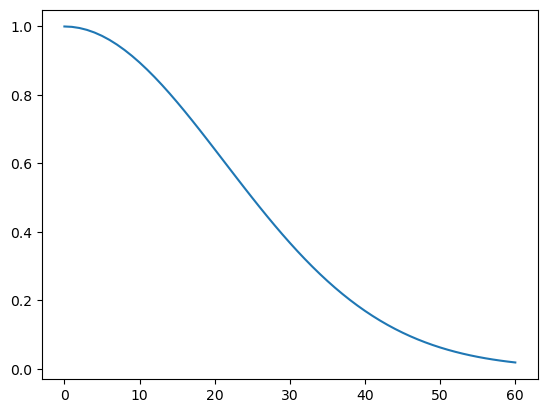

In [6]:
# Weibull distribution
weibull_dist = weibull_min(
    c=2,  # controls the shape of the curve (skewness)
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=30,  # Stretches or compresses the curve along the x-axis (spread)
)
survival_curve = weibull_dist.sf(timesteps)  # sf = survival function

plt.plot(survival_curve)
plt.show()

# Create a survival curve matrix

--> see `week_2_tutorial_survival_curves.ipynb` notebook first


In [7]:
# create survival curve matrix with placeholder zeros
survival_curve_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

![filling_survival_curve_matrix](../../img/filling_survival_curve_matrix.png)


In [8]:
# populate the survival curve matrix with shifted curves, column by column using slices
for step in timesteps:
    # at each iteration, we take 1 year less of the survival curve
    last_idx = step_max - step
    values = survival_curve[0:last_idx]
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from step to step_max
    # --> columns: only the current step
    survival_curve_matrix.loc[step:step_max, step] = values

survival_curve_matrix

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
1,0.998890,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
2,0.995565,0.998890,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
3,0.990050,0.995565,0.998890,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
4,0.982379,0.990050,0.995565,0.998890,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.030671,0.034697,0.039164,0.044108,0.049566,0.055576,0.062177,0.069406,0.077305,0.085911,...,0.972604,0.982379,0.990050,0.995565,0.998890,1.000000,0.000000,0.000000,0.00000,0.0
57,0.027052,0.030671,0.034697,0.039164,0.044108,0.049566,0.055576,0.062177,0.069406,0.077305,...,0.960789,0.972604,0.982379,0.990050,0.995565,0.998890,1.000000,0.000000,0.00000,0.0
58,0.023807,0.027052,0.030671,0.034697,0.039164,0.044108,0.049566,0.055576,0.062177,0.069406,...,0.947011,0.960789,0.972604,0.982379,0.990050,0.995565,0.998890,1.000000,0.00000,0.0
59,0.020905,0.023807,0.027052,0.030671,0.034697,0.039164,0.044108,0.049566,0.055576,0.062177,...,0.931358,0.947011,0.960789,0.972604,0.982379,0.990050,0.995565,0.998890,1.00000,0.0


# Stock driven model


In [9]:
# This is our model input
stock = data["stock"]
stock

year
1990     20
1991     21
1992     30
1993     39
1994     45
       ... 
2046    724
2047    737
2048    750
2049    763
2050    776
Name: stock, Length: 61, dtype: int64

In [10]:
# create inflow series and survival matrix with
# placeholder zeros, that we will populate
inflows = pd.Series(0, index=years, dtype=float)
cohort = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)

![stock_driven_equations](../../img/stock_driven_equations.png)

![filling_stock_driven_cohort](../../img/filling_stock_driven_cohort.png)


In [11]:
# iteratively calculate the inflows, and
# multiply the inflow with the shifted curves to get the cohorts' behavior over time
for time in timesteps:
    # calculate the difference between current stock and the sum of all
    # what remains from previous inflows
    # Also, don't forget to divide by survival_curve[0] (not always = 1)
    difference = stock.iloc[time] - cohort.loc[time, :].sum()
    inflows.iloc[time] = difference / survival_curve_matrix.loc[time, time]
    # the line below is the same as for flow driven models
    cohort.loc[:, time] = survival_curve_matrix.loc[:, time] * inflows.iloc[time]

cohort

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,19.977790,1.022210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,19.911308,1.021075,9.067617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,19.800997,1.017677,9.057547,9.123779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,19.647586,1.012039,9.027406,9.113647,6.199322,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.613416,0.035467,0.355123,0.402433,0.307277,0.294029,0.086590,0.104081,3.757512,1.182572,...,31.436844,32.224710,32.951373,33.612175,34.202844,34.719544,0.000000,0.000000,0.000000,0.000000
57,0.541037,0.031352,0.314616,0.357323,0.273441,0.262234,0.077398,0.093239,3.373596,1.064108,...,31.054954,31.904069,32.696079,33.425958,34.089025,34.680988,35.197997,0.000000,0.000000,0.000000
58,0.476139,0.027653,0.278111,0.316565,0.242790,0.233357,0.069029,0.083341,3.022182,0.955385,...,30.609607,31.516503,32.370747,33.166987,33.900166,34.565578,35.158910,35.676297,0.000000,0.000000
59,0.418095,0.024336,0.245296,0.279834,0.215096,0.207199,0.061427,0.074329,2.701364,0.855866,...,30.103674,31.064537,31.977513,32.836970,33.637521,34.374079,35.041909,35.636679,36.154505,0.000000


<Axes: xlabel='year', ylabel='year'>

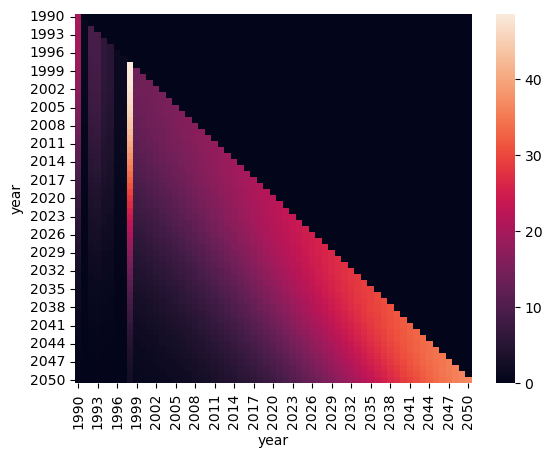

In [12]:
# set index and columns to years instead of timesteps
cohort.index = years
cohort.columns = years

# and visualize the cohort matrix with a heatmap
sns.heatmap(cohort, annot=False)

In [13]:
# calculate outflows and nas:
nas = np.diff(stock, prepend=0)  # prepending 0 assumes no initial stock
outflows = inflows - nas

# Visualize the results


In [14]:
data["stock"] = stock
data["outflow"] = outflows
data["nas"] = nas

data

,stock,inflow,outflow,nas
year,,,,
1990,20,NaN,0.000000,20
1991,21,NaN,0.022210,1
1992,30,NaN,0.067617,9
1993,39,NaN,0.123779,9
1994,45,NaN,0.199322,6
...,...,...,...,...
2046,724,NaN,21.719544,13
2047,737,NaN,22.197997,13
2048,750,NaN,22.676297,13


<Axes: xlabel='year'>

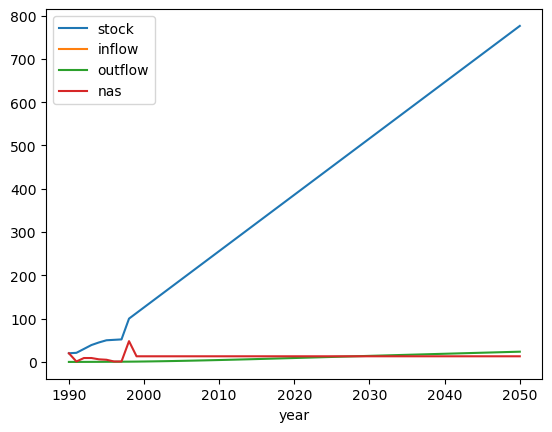

In [15]:
# Visualize on the same plot
data.plot()

<Axes: xlabel='year'>

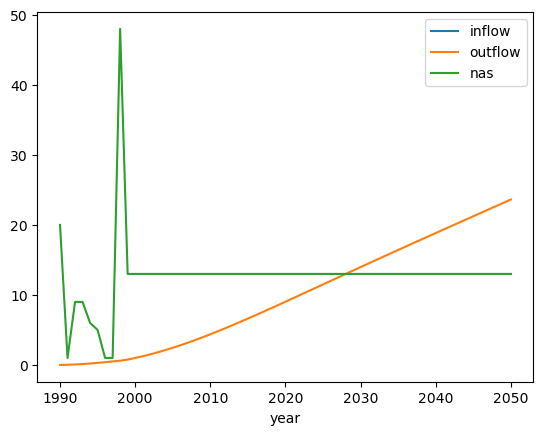

In [16]:
# Zooming in the flows and net addition to stock
data[["inflow", "outflow", "nas"]].plot()

<Axes: xlabel='year'>

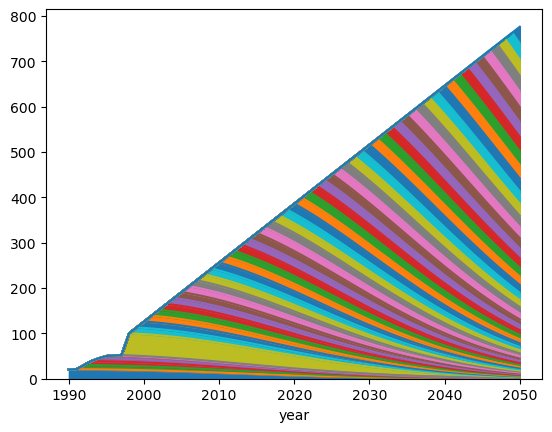

In [17]:
# Visualize the stock by cohorts
cohort.plot(kind="area", stacked=True, legend=False)

# Export output data to Excel


In [18]:
# Save the data to an Excel file
# (you may need to create the folder if it doesn't exist)
file_path = BASE_DIR / "data_output" / "week_2_tutorial_myname.xlsx"
data.to_excel(file_path, sheet_name="stock_driven")

In [19]:
# But we also want to save the cohort data in the same excel file
# without overwriting the file.
# To do that, we open an Excel file in append mode ('a')
# https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html

with pd.ExcelWriter(file_path, mode="a") as writer:
    cohort.to_excel(writer, sheet_name="cohort_stock_driven")

# Going further

--> We saw in `week_2_tutorial_survival_curves.ipynb` notebook that we could also define the `survival_curve` and the `survival_curve_matrix` as follows:


In [20]:
# Instead of a numpy array, we store the survival curve
# as a pandas Series with the appropriate index (= years)
sf = pd.Series(survival_curve, index=years)

# create survival curve matrix with placeholder zeros (same as before)
survival_curve_matrix2 = pd.DataFrame(0, index=years, columns=years, dtype=float)

# populate the survival curve matrix with shifted curves, column by column using slices
# ! This time we use the years as index instead of the timesteps
for counter, year in enumerate(years):
    # at each iteration, we take 1 year less of the survival curve
    last_idx = end_year - counter
    values = sf.loc[:last_idx].values
    # and we assign the sliced values to the sliced matrix:
    # --> rows: from current year to the end year
    # --> columns: only the current year
    survival_curve_matrix2.loc[year:end_year, year] = values

Now let's utilize numpy and pandas capacities to **optimize** our stock driven model


There are different types of matrix multiplications:

- the **dot product** (using the `np.dot()` function or the `@` operator)?
- the **element-wise matrix multiplication** (`np.multiply()` function or `*` operator)

The **dot product** does the following:

$$
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{11} f_1 + a_{12} f_2  + a_{13} f_3  \\
a_{21} f_1 + a_{22} f_2  + a_{23} f_3  \\
a_{31} f_1 + a_{32} f_2  + a_{33} f_3  \\
\end{bmatrix}
$$

Now assuming that

- the matrix $\mathbf{A}$ represents the `survival_curve_matrix`
- and the vector $\mathbf{f}$ represents the `inflows`,

we get:

$$
\begin{bmatrix}
a_{1} & 0 & 0 \\
a_{2} & a_{1} & 0 \\
a_{3} & a_{2} & a_{1} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
f_1 \\
f_2 \\
f_3
\end{bmatrix}
=
\begin{bmatrix}
a_{1} f_1 \\
a_{2} f_1 + a_{1} f_2  \\
a_{3} f_1 + a_{2} f_2  + a_{1} f_3  \\
\end{bmatrix}
$$

You may recognize the `stock` vector $\mathbf{s}$ as the result

In other words, we have the following system of linear equations:

$$
\begin{align}
\mathbf{A} \cdot \mathbf{f} &= \mathbf{s} \\
\mathbf{f} &= \mathbf{A}^{-1} \cdot \mathbf{s}
\end{align}
$$

And `scipy.linalg.solve()` can help us solve it

$$\mathbf{f} = \text{solve}(\mathbf{A}, \mathbf{s})$$


In [21]:
# the linear algebra library in scipy allows us to solve this
# but it returns a numpy array, so we convert it into a Pandas Series
inflows2 = solve(survival_curve_matrix2, stock)
inflows2 = pd.Series(inflows2, index=years)
inflows2

year
1990    20.000000
1991     1.022210
1992     9.067617
1993     9.123779
1994     6.199322
          ...    
2046    34.719544
2047    35.197997
2048    35.676297
2049    36.154505
2050    36.632675
Length: 61, dtype: float64

In [22]:
# Check that they are indeed the same
# always use np.allclose() instead of == to compare floats
np.allclose(inflows2, inflows)

True

# More information and tips


- [Statistical functions in scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- the `enumerate()` function on [W3school](https://www.w3schools.com/python/ref_func_enumerate.asp) or [Programiz](https://www.programiz.com/python-programming/methods/built-in/enumerate)
- [Pandas excel writer](https://pandas.pydata.org/docs/reference/api/pandas.ExcelWriter.html)
- Difference between `np.dot()`, `np.multiply()` and `np.matmul()` on [codeacademy](https://www.codecademy.com/article/numpy-matrix-multiplication-a-beginners-guide) or [digitalocean](https://www.digitalocean.com/community/tutorials/numpy-matrix-multiplication)
- [Scipy Solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) from the [Linear Algebra library](https://docs.scipy.org/doc/scipy/reference/linalg.html)
